Implemente los métodos AB5 y AM5 en MATLAB o Phyton. Primero AB5 como método explícito independiente, luego AM5 como método implícito independiente y finalmente una tercera rutina que utilice AB5 como predictor y AM5 como corrector. En todos los casos use un método Runge-Kutta apropiado para inicializar los métodos.
Ponga a prueba los métodos con los siguientes PVIs:

*   $y'=-2ty^2,t\in (0,1),  y(0)=1$. Con solución exacta $y(t)=1/(1+t^2)$.
*  $y'=t+2ty,t\in (0,1),  y(0)=0$. Con solución exacta $y(t)=\frac{1}{2}(e^{t^2}-1)$.

  En cada caso, grafique la solución numérica encontrada comparada con la solución exacta y haga estimaciones numéricas del orden del método.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [17]:
import pandas as pd
from typing import Callable, Tuple, List, Dict, Any


def get_convergence_order(e1: float, e2: float, n1: int, n2: int) -> float:
    """
    Calculate the convergence order based on two errors and the corresponding number of subintervals.
    """
    return np.log(e1 / e2) / np.log(n2 / n1)


def approximate_solution(
    method: Callable,
    h: float,
    t0: float,
    tf: float,
    y0: float,
    dy_dt: Callable[[float, float], float],
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the approximate solution using the given method.

    Parameters:
        method: A function that computes the next y value.
        h: Step size.
        t0: Initial time.
        tf: Final time.
        y0: Initial value.
        dy_dt: Function that returns the derivative at a given time and y.

    Returns:
        A tuple (t_values, y_values) containing the time points and the approximate solution.
    """
    t_values = np.arange(t0, tf + h, h)
    y_values = np.empty_like(t_values, dtype=float)
    y_values[0] = y0

    for j in range(len(t_values) - 1):
        # Compute derivative at current time and value
        dy = dy_dt(t_values[j], y_values[j])
        # Compute next value using the given method
        y_values[j + 1] = method(yj=y_values[j], h=h, dy=dy, t=t_values[j], dy_dt=dy_dt)

    return t_values, y_values


def compute_approximations(
    method: Callable,
    n_values: List[int],
    t0: float,
    tf: float,
    y0: float,
    dy_dt: Callable[[float, float], float],
    analytical: Callable[[float], float],
) -> pd.DataFrame:
    """
    Compute the approximation and convergence data for various step sizes.

    Parameters:
        method: The numerical method to use.
        n_values: List of numbers of subintervals to test.
        t0: Initial time.
        tf: Final time.
        y0: Initial value.
        dy_dt: Function computing dy/dt.
        analytical: The analytical solution (a function of time).

    Returns:
        A pandas DataFrame with columns 'N', 'h', 'y_aprox', 'y_exact', 'error', and 'convergence_rate'.
    """
    results: Dict[str, List[Any]] = {
        "N": [],
        "h": [],
        "y_aprox": [],
        "y_exact": [],
        "error": [],
        "convergence_rate": [],
    }

    for i, n in enumerate(n_values):
        h = (tf - t0) / n
        t_vals, y_aprox_vals = approximate_solution(method, h, t0, tf, y0, dy_dt)
        y_aprox = y_aprox_vals[-1]
        y_exact = analytical(tf)
        error = abs(y_aprox - y_exact)

        results["N"].append(n)
        results["h"].append(h)
        results["y_aprox"].append(y_aprox)
        results["y_exact"].append(y_exact)
        results["error"].append(error)

        if i > 0:
            prev_error = results["error"][i - 1]
            prev_n = results["N"][i - 1]
            conv_order = get_convergence_order(prev_error, error, prev_n, n)
            results["convergence_rate"].append(conv_order)
        else:
            results["convergence_rate"].append(np.nan)

    return pd.DataFrame(results)


def plot_approximation(
    t_vals: np.ndarray,
    y_aprox: np.ndarray,
    t_analytical: np.ndarray,
    y_analytical: np.ndarray,
    h: float,
    method_name: str,
) -> None:
    """
    Plot the approximate solution alongside the analytical solution.

    Parameters:
        t_vals: Time points for the approximate solution.
        y_aprox: The approximate solution values.
        t_analytical: Time points for the analytical solution.
        y_analytical: The analytical solution values.
        h: Step size used.
        method_name: A string describing the numerical method.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(
        t_vals,
        y_aprox,
        marker="^",
        linestyle="",
        markersize=4,
        color="r",
        label=f"Approximation (h={h:.5f})",
    )
    plt.plot(t_analytical, y_analytical, label="Analytical solution")
    plt.title(f"Approximation using {method_name}", fontsize=15)
    plt.xlabel("time (t)")
    plt.ylabel("y(t)")
    plt.grid(True)
    plt.legend()
    plt.show()


def run_simulation(
    method: Callable,
    method_name: str,
    n_values: List[int],
    t0: float,
    tf: float,
    y0: float,
    dy_dt: Callable[[float, float], float],
    analytical: Callable[[float], float],
) -> pd.DataFrame:
    """
    Run the simulation for different step sizes, plot the results, and return a summary DataFrame.

    Parameters:
        method: The numerical method to be used.
        method_name: A name/description for the method.
        n_values: A list of subinterval counts (which determines h).
        t0: Initial time.
        tf: Final time.
        y0: Initial value.
        dy_dt: Function computing dy/dt.
        analytical: The analytical solution as a function of time.

    Returns:
        A pandas DataFrame summarizing the computed approximations, errors, and convergence rates.
    """
    # Prepare analytical solution for plotting (use a fine grid)
    t_analytical = np.linspace(t0, tf, 256)
    y_analytical = np.array([analytical(t) for t in t_analytical])

    # Loop over all n-values to compute and plot approximations
    for n in n_values:
        h = (tf - t0) / n
        t_vals, y_aprox_vals = approximate_solution(method, h, t0, tf, y0, dy_dt)
        plot_approximation(
            t_vals, y_aprox_vals, t_analytical, y_analytical, h, method_name
        )

    # Compute convergence data and results table
    results_df = compute_approximations(method, n_values, t0, tf, y0, dy_dt, analytical)
    print(results_df)
    return results_df


In [25]:
number_of_subintervals = [8, 16, 32, 64]

t0 = 0.0
tf = 1
y0 = 1.0

def dy_dt(t, y):
    return -2 * t * y **2

def analytical(t, **kwargs):
    return 1 / (1 + (t **2))

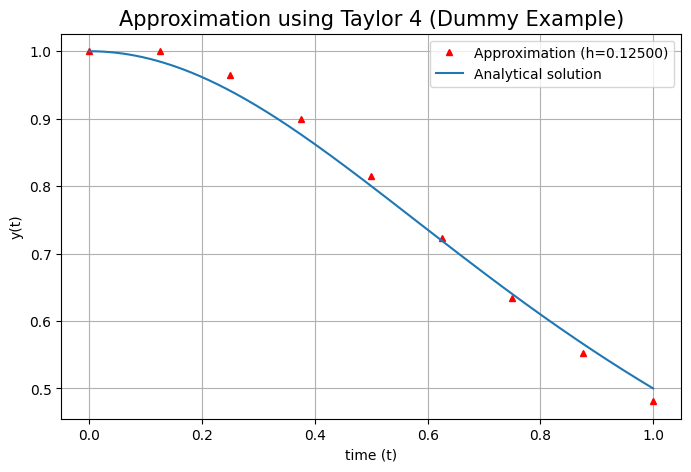

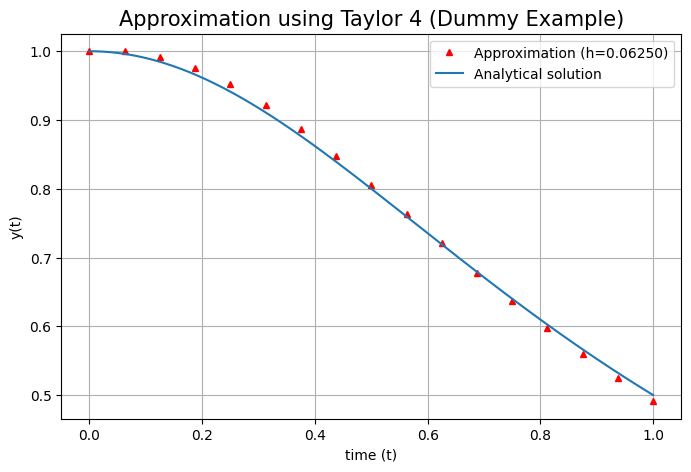

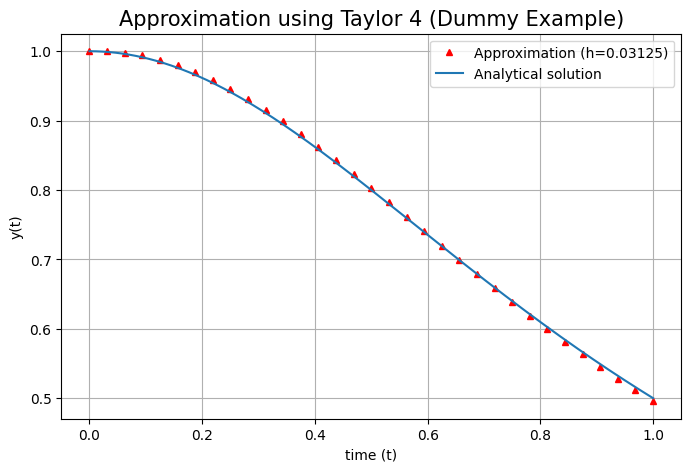

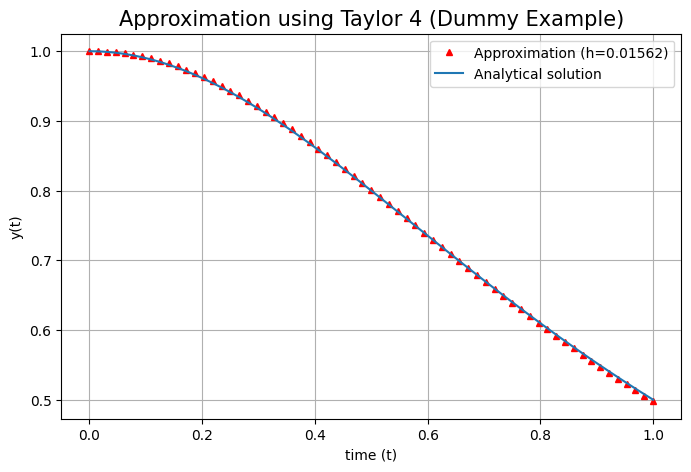

    N         h   y_aprox  y_exact     error  convergence_rate
0   8  0.125000  0.480970      0.5  0.019030               NaN
1  16  0.062500  0.490999      0.5  0.009001          1.080124
2  32  0.031250  0.495602      0.5  0.004398          1.033243
3  64  0.015625  0.497824      0.5  0.002176          1.015168


,N,h,y_aprox,y_exact,error,convergence_rate
0,8,0.125000,0.480970,0.5,0.019030,NaN
1,16,0.062500,0.490999,0.5,0.009001,1.080124
2,32,0.031250,0.495602,0.5,0.004398,1.033243
3,64,0.015625,0.497824,0.5,0.002176,1.015168


In [26]:
def dy2_dt(t, y):
    return 2 * y * dy_dt(t, y)


def dy3_dt(t, y):
    return 2 * y * dy2_dt(t, y) + 2 * (dy_dt(t, y)) ** 2


def dy4_dt(t, y):
    return 2 * y * dy3_dt(t, y) + 6 * dy_dt(t, y) * dy2_dt(t, y)


def taylor_4(yj, h, t, **kwargs):
    return (
        yj
        + h * dy_dt(t, yj)
        + (h**2) / 2 * dy2_dt(t, yj)
        + (h**3) / 6 * dy3_dt(t, yj)
        + (h**4) / 24 * dy4_dt(t, yj)
    )


run_simulation(
    method=taylor_4,
    method_name="Taylor 4 (Dummy Example)",
    n_values=number_of_subintervals,
    t0=t0,
    tf=tf,
    y0=y0,
    dy_dt=dy_dt,
    analytical=analytical,
)